# 02_bnn_only

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
import bnn as bnn
from bnn import *
import wandb
wandb.login()

wandb: Currently logged in as: lilacs2039. Use `wandb login --relogin` to force relogin


True

In [ ]:
# # CUDAのエラーが同期的に報告され、エラーが起きた正確な場所を特定する
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Setup

In [ ]:
from fastai.tabular.all import *
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from fastai.callback.wandb import WandbCallback
import seaborn as sns

## Prepare Dataset

In [ ]:
# Iris load & make DataFrame
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

cat_names = []
cont_names = iris.feature_names
dep_var = 'target'

In [ ]:
f'num train_df：{len(train_df)}'

'num train_df：120'

## DataLoader

In [ ]:
dls = TabularDataLoaders.from_df(train_df, 
                                 path='.', 
                                 procs = [Categorify, FillMissing, Normalize],
                                 cat_names=cat_names,
                                 cont_names=cont_names, 
                                 y_names=dep_var, 
                                 y_block=CategoryBlock, 
                                 valid_idx=list(valid_df.index),
                                 shuffle=True,
                                 bs=64,
                                )

In [ ]:
f'num train_ds(dataset) {len(dls.train_ds)}'

'num train_ds(dataset) 90'

batch example

In [ ]:
bx_cat, bx, by = dls.one_batch()
bx_cat, bx, by

(tensor([], size=(64, 0), dtype=torch.int64),
 tensor([[-1.0066,  0.4755, -1.5564, -1.3989],
         [-0.8837, -1.2364, -0.4970, -0.1922],
         [-1.1296, -1.2364,  0.3858,  0.6123],
         [-0.0232, -0.7473,  0.7390,  0.8805],
         [-0.1461, -0.9918, -0.2027, -0.3263],
         [-0.0232, -0.9918,  0.0916, -0.0581],
         [ 0.4685,  0.9647,  0.9156,  1.4168],
         [-0.3920,  2.9212, -1.4387, -1.3989],
         [-0.0232, -0.5027,  0.7390,  1.5509],
         [ 1.3290,  0.2310,  0.9156,  1.1486],
         [-0.7608, -0.7473,  0.0327,  0.2101],
         [ 0.2226, -0.0136,  0.5624,  0.7464],
         [ 0.5914,  0.9647,  1.0333,  1.5509],
         [-0.2691, -0.7473,  0.2093,  0.0760],
         [ 1.3290,  0.4755,  1.0921,  1.4168],
         [-1.4984,  0.9647, -1.4387, -1.2648],
         [-0.5149,  2.1875, -1.2622, -1.1308],
         [ 0.2226, -1.9701,  0.0916, -0.3263],
         [ 1.6978, -0.0136,  1.1510,  0.4782],
         [ 0.3456, -0.9918,  1.0333,  0.2101],
         [ 0.5

In [ ]:
bx.mean(), bx.std()

(tensor(-0.0435), tensor(0.9999))

# CallBacks

In [ ]:
from fastai.callback.core import Callback
class CustomWandbCallback(WandbCallback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def after_batch(self):
        super().after_batch()
        if self.training:
            self.log_custom_metrics()
    def log_custom_metrics(self):
        self._wandb_step += 1
        custom_metrics = {
            'custom_train_loss': self.learn.loss.item(),
            'custom_lr': self.opt.hypers[-1]['lr'],
            'update_permission_coef' : bnn.update_permission_coef,
            **{f"{name}": wandb.Histogram(param.data.cpu().numpy())
                for name, param in model.named_parameters()},
            **bnn.logger.getLog()
        }
        bnn.logger.clear()
        wandb.log(custom_metrics, step=self._wandb_step)
    def after_fit(self):
        for title,ax in bnn.logger.createHeatmaps().items():
            wandb.log({f"{title}": wandb.Image(ax, f"{title}")})
        bnn.logger.clear_heatmap()

class BinaryLearnCallback(Callback):
    def __init__(self, binary_nets:list, **kwargs): 
        super().__init__(**kwargs)
        self.binary_nets = binary_nets
    def after_step(self):  # after update of parameter
        # for net in self.binary_nets: net.is_update = True
        bnn.is_update = True
        self.learn.model(*self.learn.xb)
        bnn.is_update = False


# Model

In [ ]:
th_depth = bnn.TH_DEPTH3
class Model02(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth_features):
        super(Model02, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.norm = torch.nn.BatchNorm1d(input_dim)
        self.binary_net = bnn.Sequential([
            bnn.Binarize(depth_ths=th_depth),
            # bnn.BMAB(input_dim, hidden_dim),
            bnn.BMAB(input_dim, hidden_dim, depth_features),
            bnn.BMA(hidden_dim, output_dim, depth_features),]
        )

    def forward(self, x_cat, x_cont):
        x = self.norm(x_cont)
        x = self.binary_net(x)
        return x

input_dim = len(cont_names)
hidden_dim = 64
output_dim = len(iris.target_names)
depth_features = len(th_depth)
# depth_features = 1
model = Model02(input_dim, hidden_dim, output_dim, depth_features)

In [ ]:
model

Model02(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (relu): ReLU()
  (norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (binary_net): Sequential()
)

## Model Graph

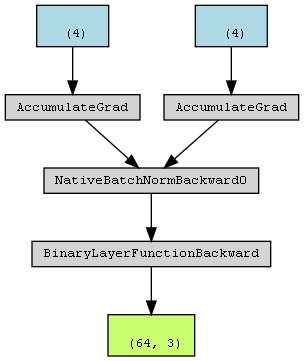

In [ ]:
import torchvision.models as models
from torchviz import make_dot

dot = make_dot(model(bx_cat, bx))
dot.format = 'png'
dot_path = 'outputs/graph_image'
dot.render(dot_path)

from IPython.display import Image
display(Image(filename=dot_path+'.png'))

# Learn

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy,
               cbs=[
                   # CustomWandbCallback(), 
                   BinaryLearnCallback([model.binary_net]),
                   ShowGraphCallback()])

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.213517,2.775670,0.000000,00:02
1,1.851515,1.532509,0.433333,00:01
2,1.808034,0.913916,0.433333,00:01
3,1.613491,0.882131,0.766667,00:01
4,1.466414,0.815674,0.833333,00:01


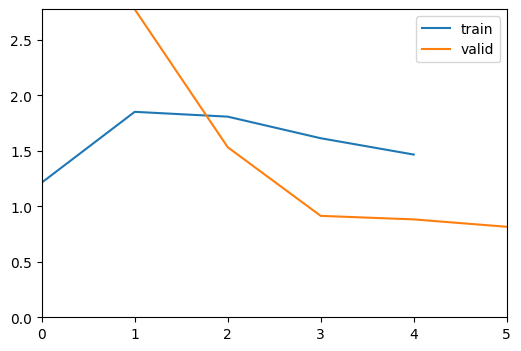

In [ ]:
learn.dls.bs=32  #64
bnn.update_permission_coef = 0
learn.fit_one_cycle(5, lr_max=1e-2)

{'Seq.000-Binarize/forward_out-mean_of_bits-heatmap': <Axes: title={'center': 'Seq.000-Binarize/forward_out-mean_of_bits-heatmap'}, xlabel='Steps'>,
 'Seq.000-Binarize/forward_out-mean_of_bits-d-heatmap': <Axes: title={'center': 'Seq.000-Binarize/forward_out-mean_of_bits-d-heatmap'}, xlabel='Steps'>,
 'Seq.000-Binarize/forward_out-mean_of_bits-x-heatmap': <Axes: title={'center': 'Seq.000-Binarize/forward_out-mean_of_bits-x-heatmap'}, xlabel='Steps'>,
 'Seq.001-BMAB/forward_out-mean_of_bits-heatmap': <Axes: title={'center': 'Seq.001-BMAB/forward_out-mean_of_bits-heatmap'}, xlabel='Steps'>,
 'Seq.001-BMAB/forward_out-mean_of_bits-d-heatmap': <Axes: title={'center': 'Seq.001-BMAB/forward_out-mean_of_bits-d-heatmap'}, xlabel='Steps'>,
 'Seq.001-BMAB/forward_out-mean_of_bits-x-heatmap': <Axes: title={'center': 'Seq.001-BMAB/forward_out-mean_of_bits-x-heatmap'}, xlabel='Steps'>,
 'Seq.001-BMAB/BinaryTensor-weights': <Axes: title={'center': 'Seq.001-BMAB/BinaryTensor-weights'}, xlabel='Steps'

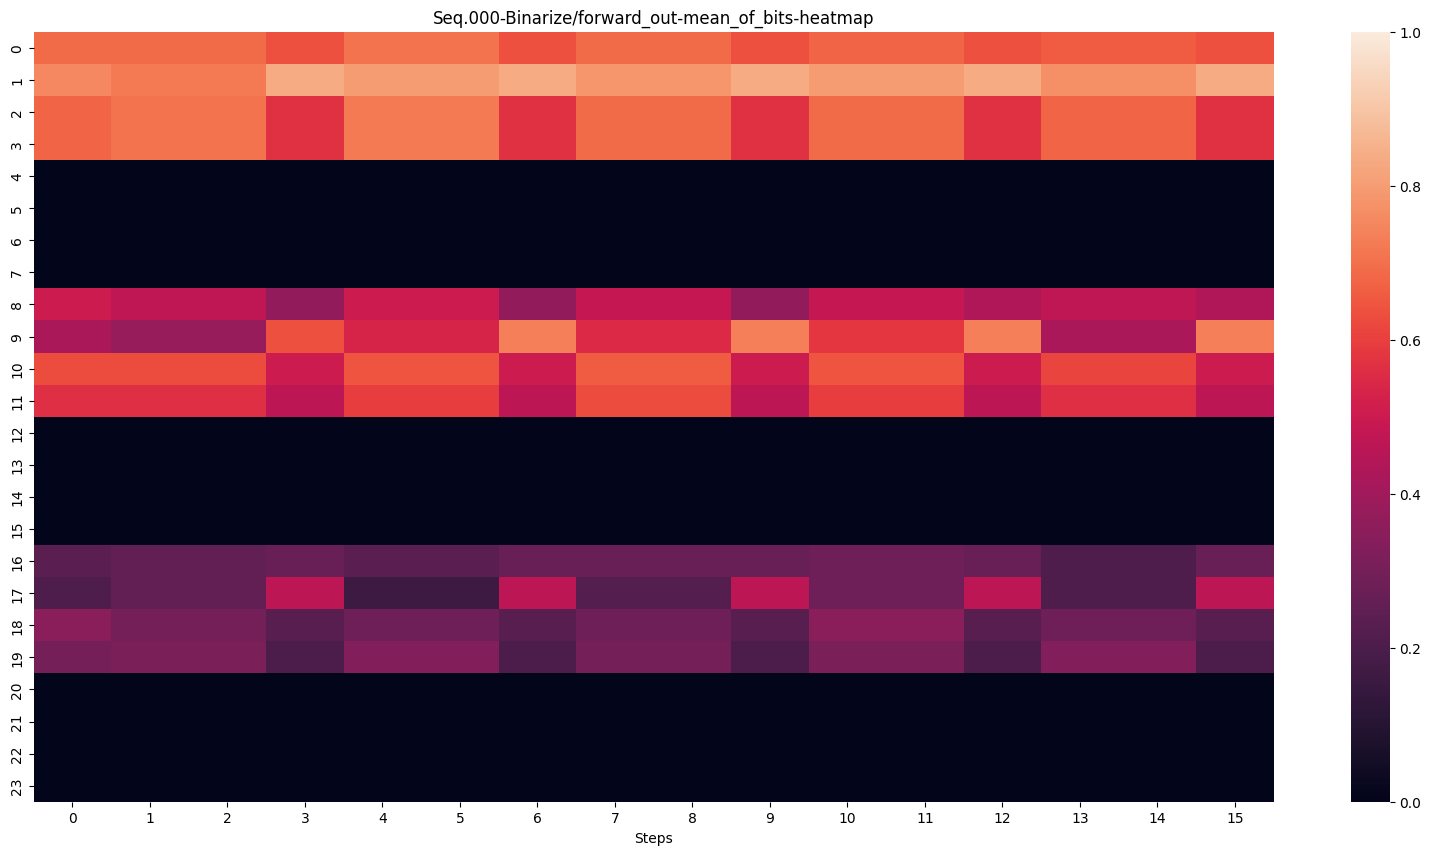

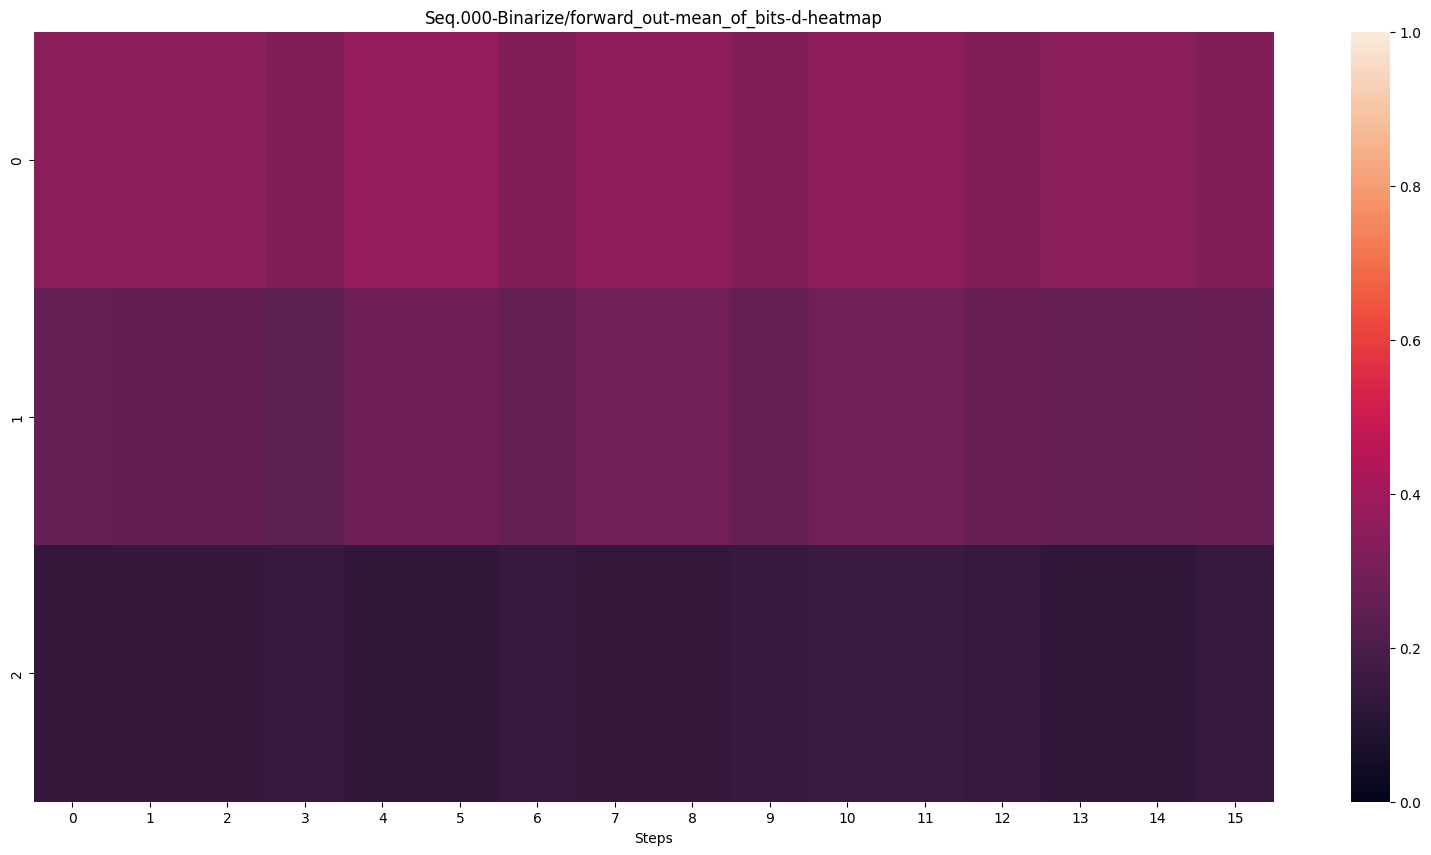

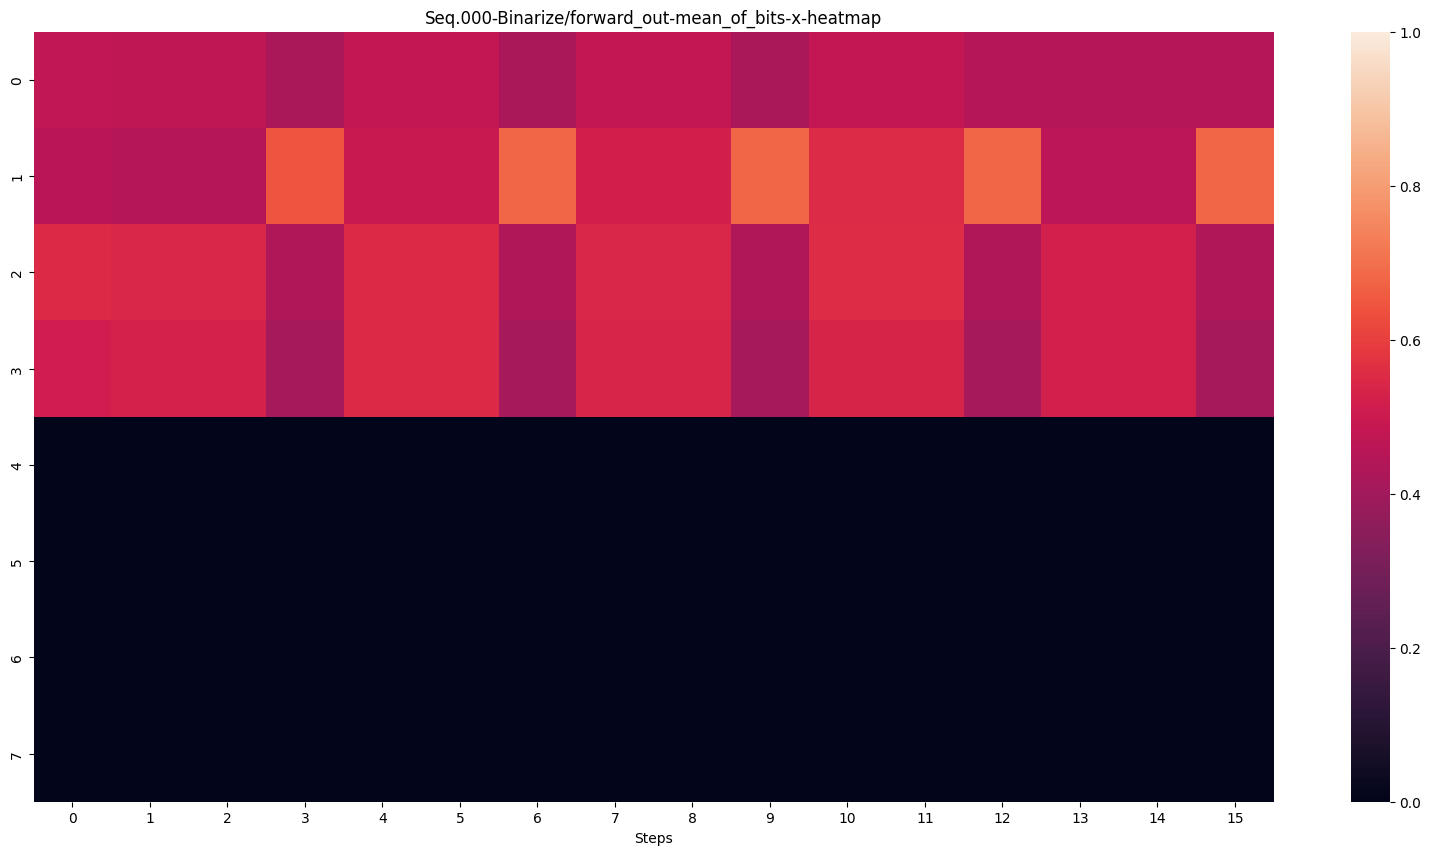

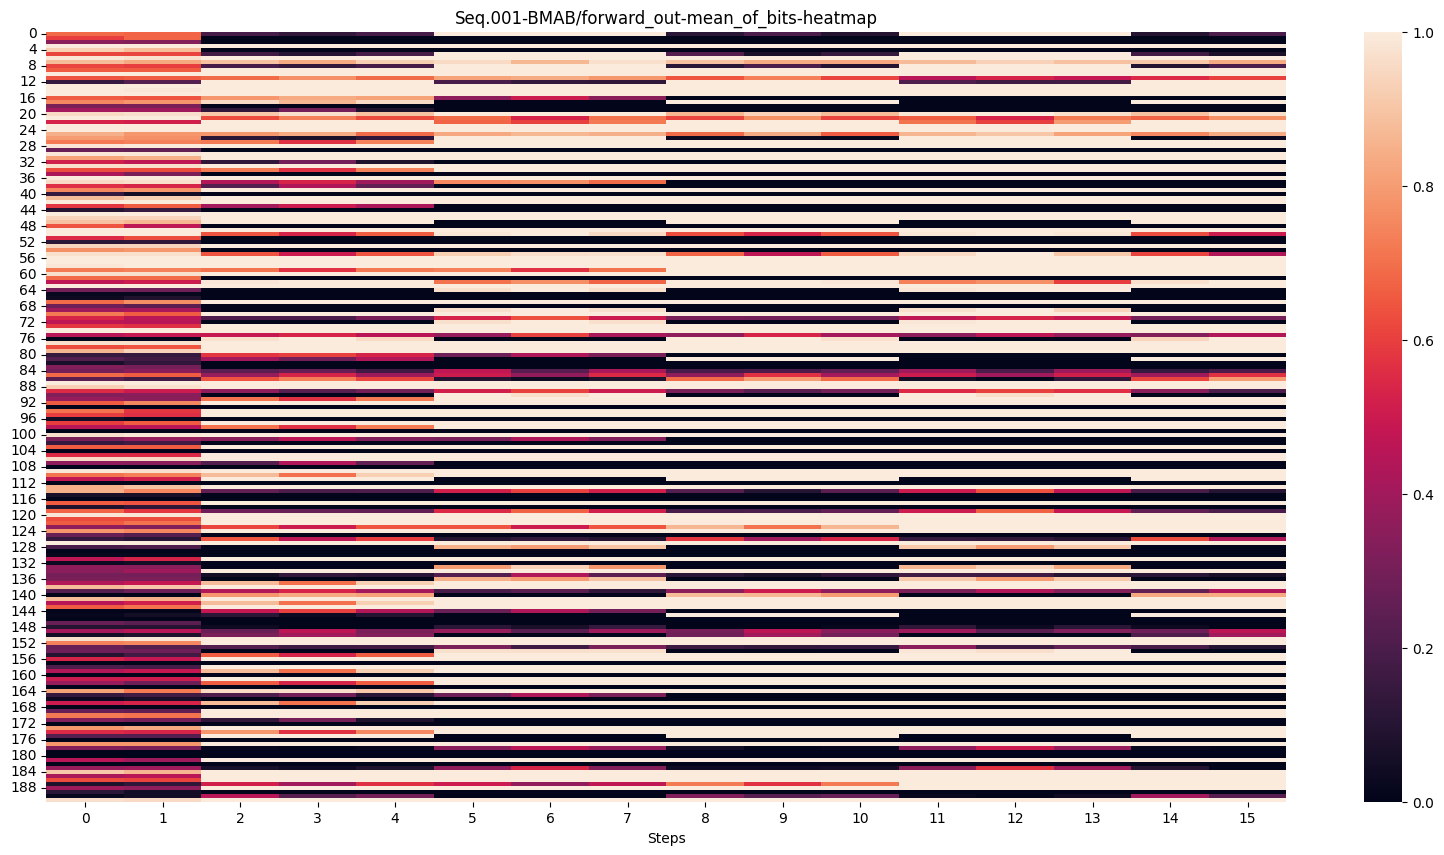

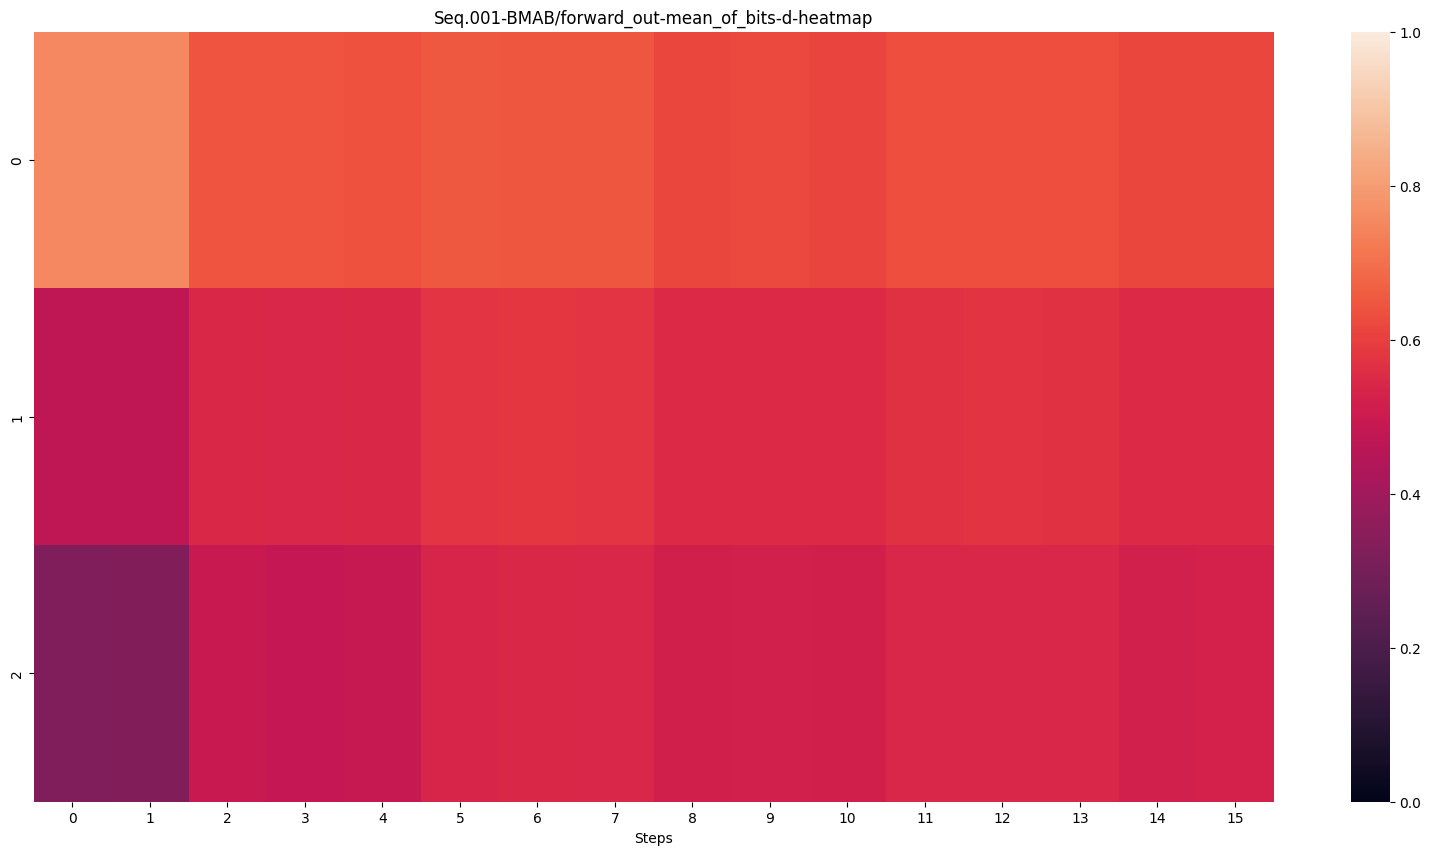

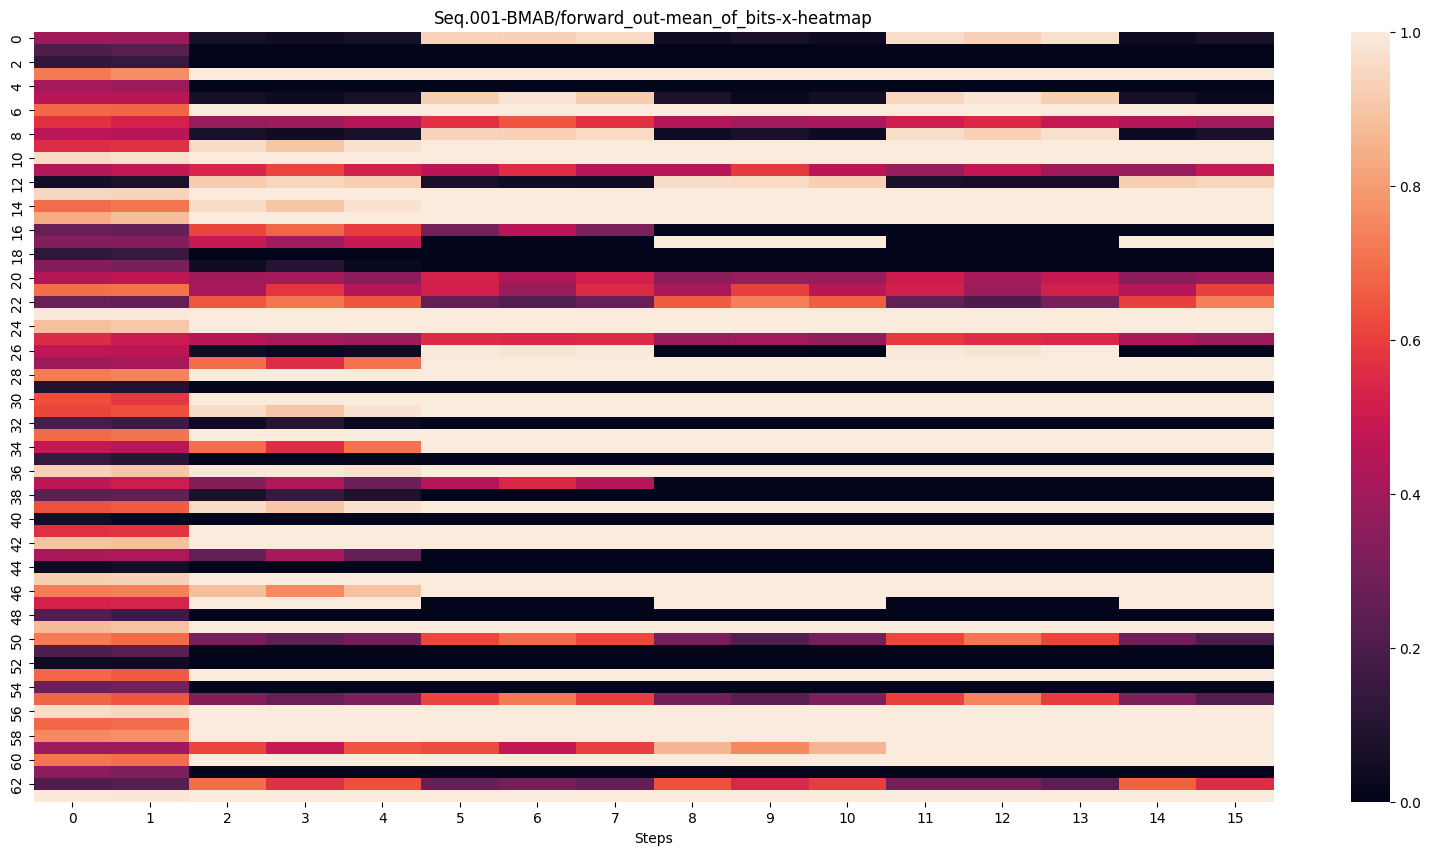

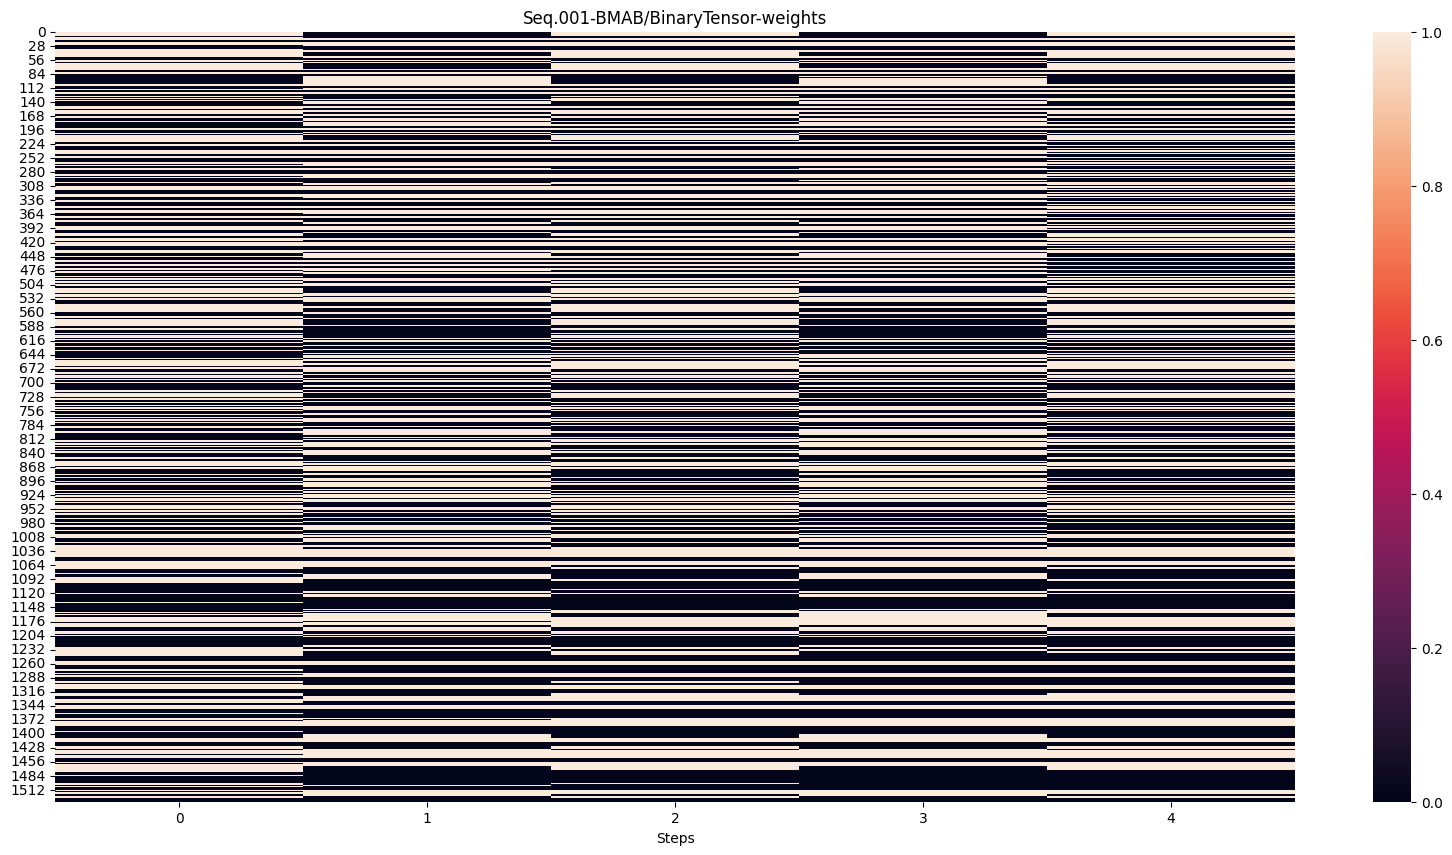

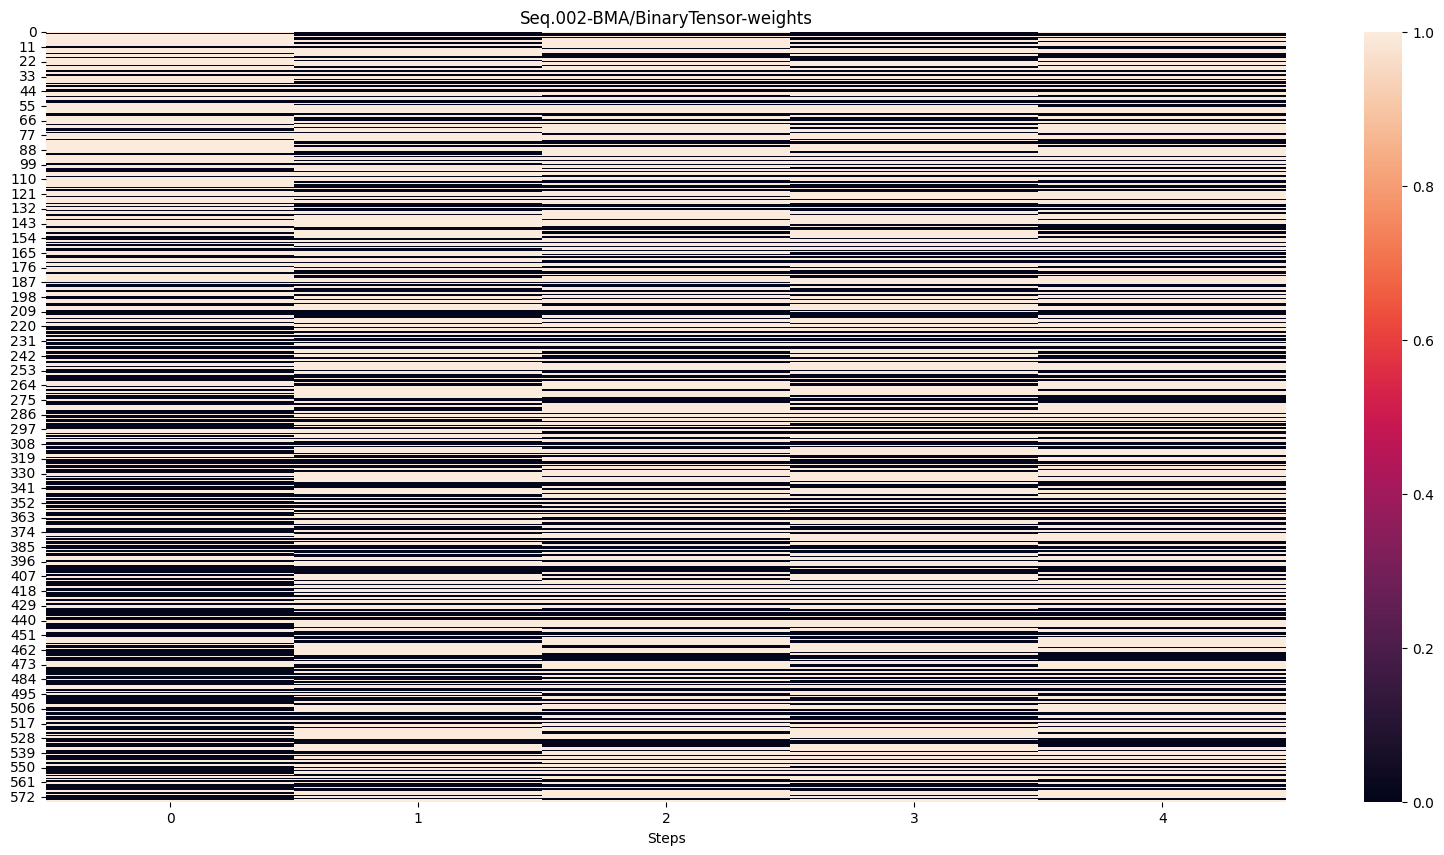

In [ ]:
bnn.logger.createHeatmaps()

epoch,train_loss,valid_loss,accuracy,time
0,0.810729,1.073695,0.666667,00:01
1,0.866056,0.314092,0.966667,00:01
2,0.699754,0.454803,0.800000,00:01
3,0.723673,0.553936,0.733333,00:01
4,0.698921,0.263710,0.966667,00:01


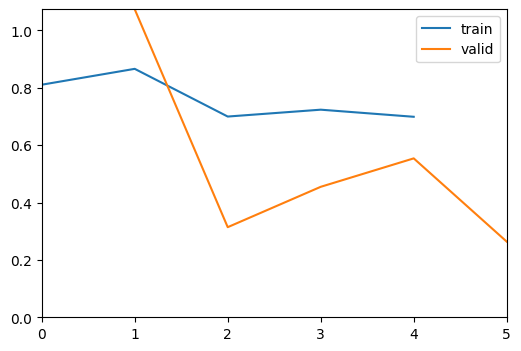

In [ ]:
learn.dls.bs=len(dls.train_ds)
bnn.update_permission_coef = 1
learn.fit_one_cycle(5, lr_max=1e-3)

# Results

In [ ]:
learn.show_results()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_pred
0,-1.006646,-2.459230,-0.202730,-0.326267,1.0,1.0
1,1.083134,0.230977,0.326985,0.210062,1.0,1.0
2,0.591421,-1.236408,0.680128,0.880474,2.0,1.0
3,-0.023220,-0.747280,0.150413,-0.326267,1.0,1.0
4,-1.006646,1.209234,-1.497589,-1.264843,0.0,0.0
5,-0.883718,1.942927,-1.144446,-1.130761,0.0,0.0
6,-0.514933,1.698363,-1.379875,-1.398925,0.0,0.0
7,-1.252502,0.964670,-1.321018,-1.398925,0.0,0.0
8,-0.760790,1.209234,-1.379875,-1.398925,0.0,0.0


## wandb(web) ver.

In [ ]:
%stop

epoch,train_loss,valid_loss,accuracy,time
0,1.137123,2.114404,0.000000,00:01
1,1.556313,1.092632,0.433333,00:01
2,1.416190,0.844464,0.800000,00:01
3,1.246397,0.789863,0.666667,00:02
4,1.149631,0.754652,0.666667,00:01
5,1.076183,0.756017,0.800000,00:01
6,1.026508,0.802333,0.700000,00:01
7,1.004211,0.545457,0.833333,00:01
8,0.954631,0.571899,0.900000,00:01
9,0.917310,0.435846,0.900000,00:01


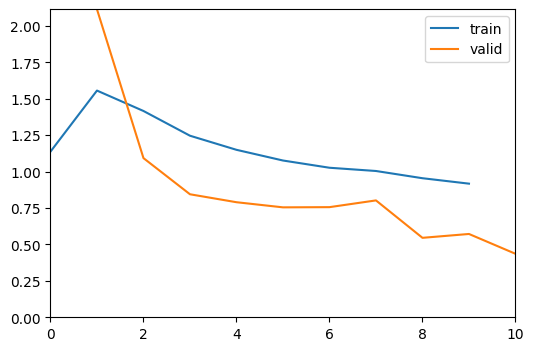

epoch,train_loss,valid_loss,accuracy,time
0,0.517720,0.391076,0.900000,00:01
1,0.497227,0.541551,0.733333,00:01
2,0.511230,0.487923,0.766667,00:01
3,0.498786,0.329256,0.900000,00:01
4,0.477201,0.309243,0.866667,00:01
5,0.449132,0.231358,0.933333,00:01
6,0.415702,0.349003,0.866667,00:01
7,0.414782,0.326123,0.866667,00:01
8,0.408412,0.326485,0.933333,00:01
9,0.408279,0.423998,0.800000,00:01


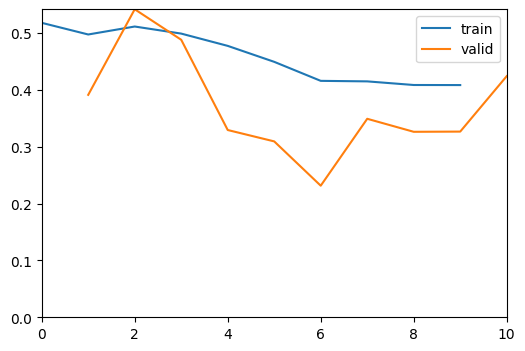

Seq.000-Binarize/backward_in - flip_ratio,▃██████████▁▃▂▁▁▁▂▁▁
Seq.001-BMAB/BinaryTensor-update_ratio,▅▇▇▇▇▆▇▇▇█▃▁▁▁▁▁▁▁▁▁
Seq.001-BMAB/backward_in - flip_ratio,▃▆▇████████▂▂▂▂▁▁▂▁▁
Seq.001-BMAB/backward_out - flip_ratio,▃██████████▁▃▂▁▁▁▂▁▁
Seq.002-BMA/BinaryTensor-update_ratio,▄▆▇███████▃▁▁▁▁▁▁▁▁▁
Seq.002-BMA/backward_out - flip_ratio,▃▆▇████████▂▂▂▂▁▁▂▁▁
accuracy,▁▄▇▆▆▇▆▇███▆▇██████▇
custom_lr,▁▄▇█▇▆▅▃▂▁▁▁▂▂▂▂▁▁▁▁
custom_train_loss,▅█▅▃▃▃▃▄▂▃▂▂▂▂▂▁▁▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


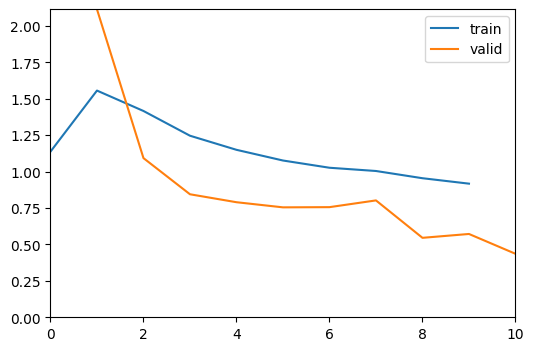

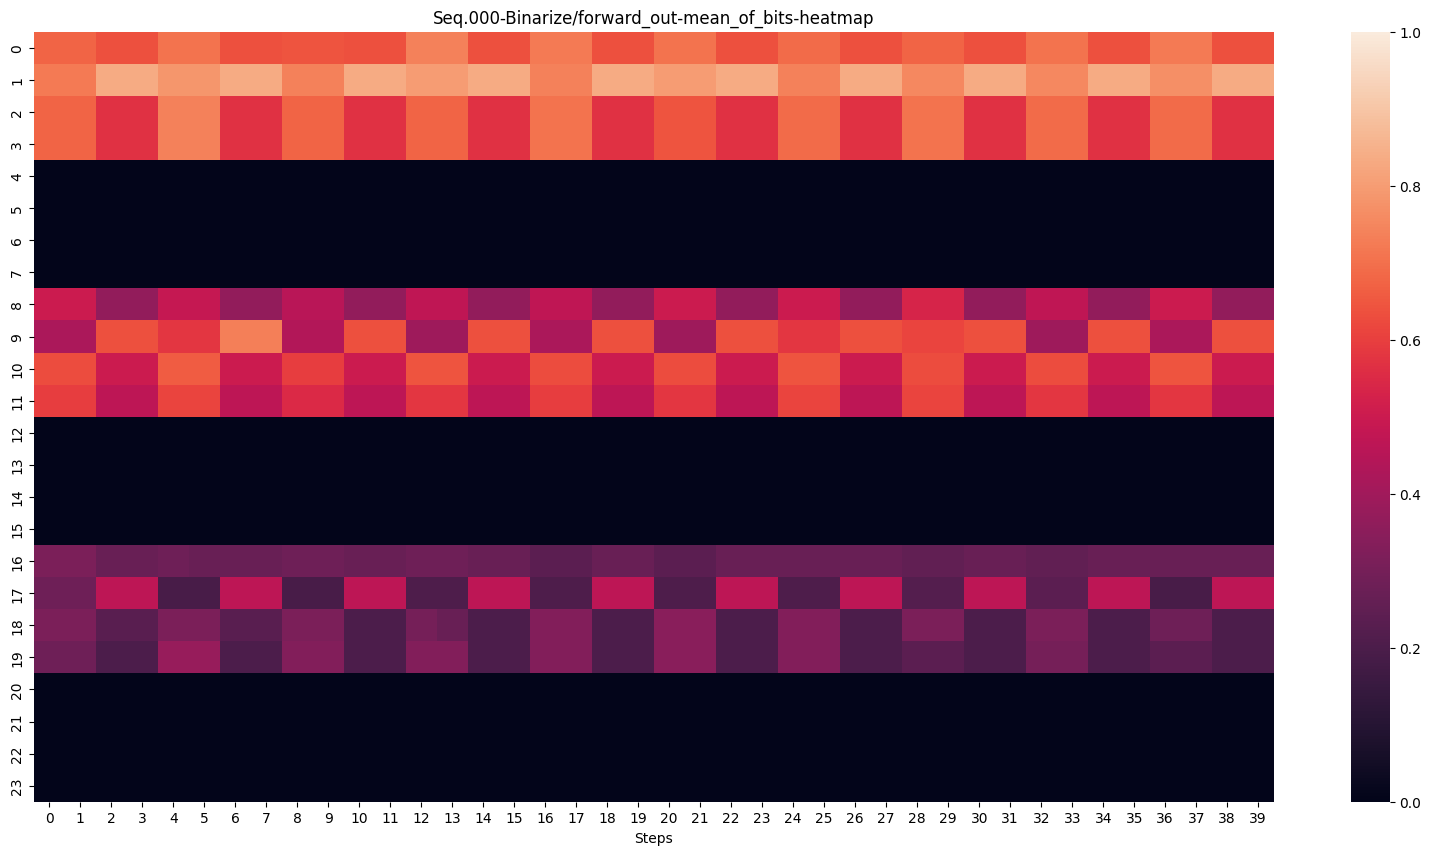

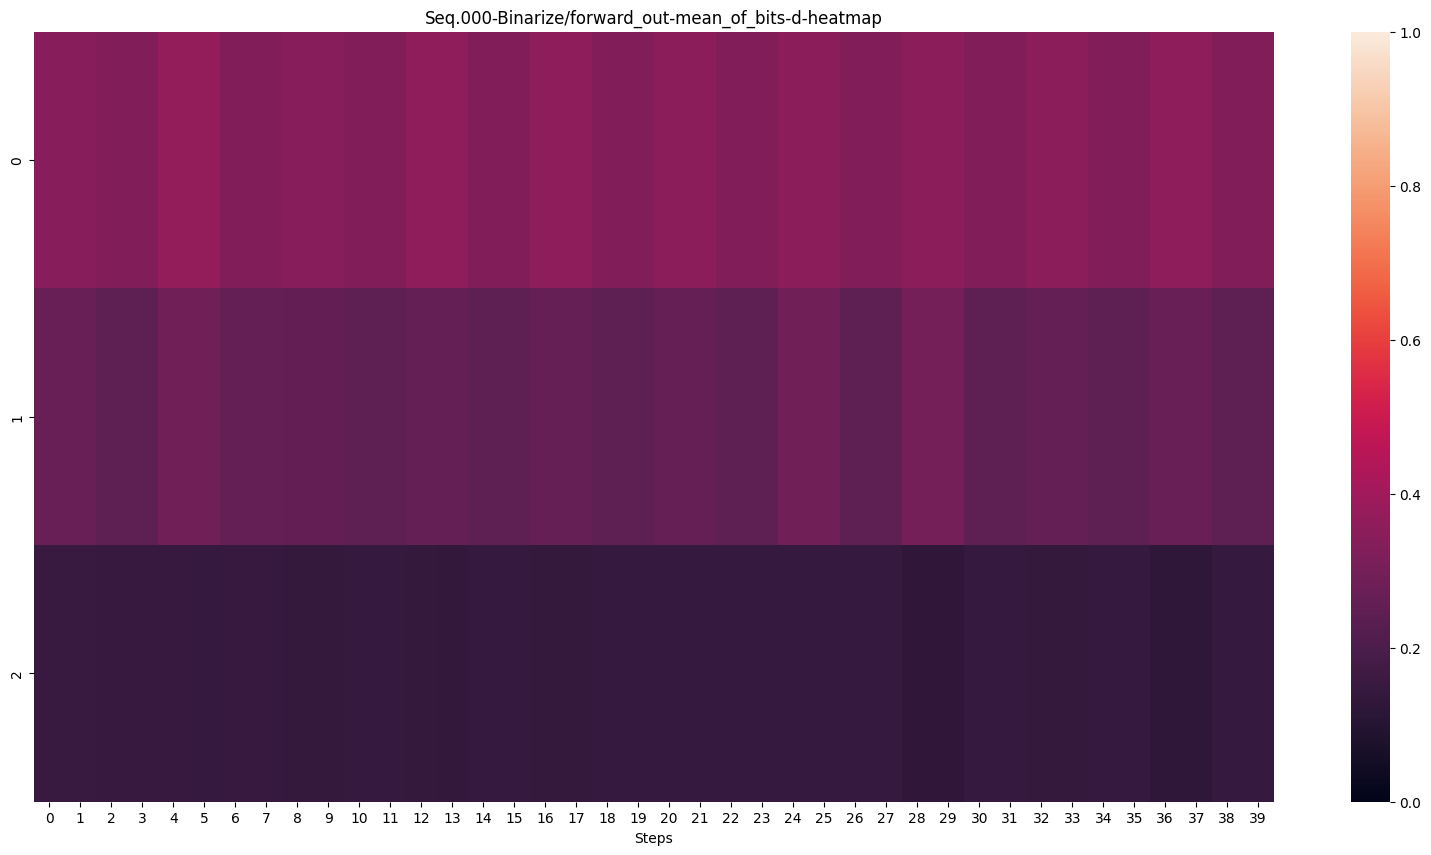

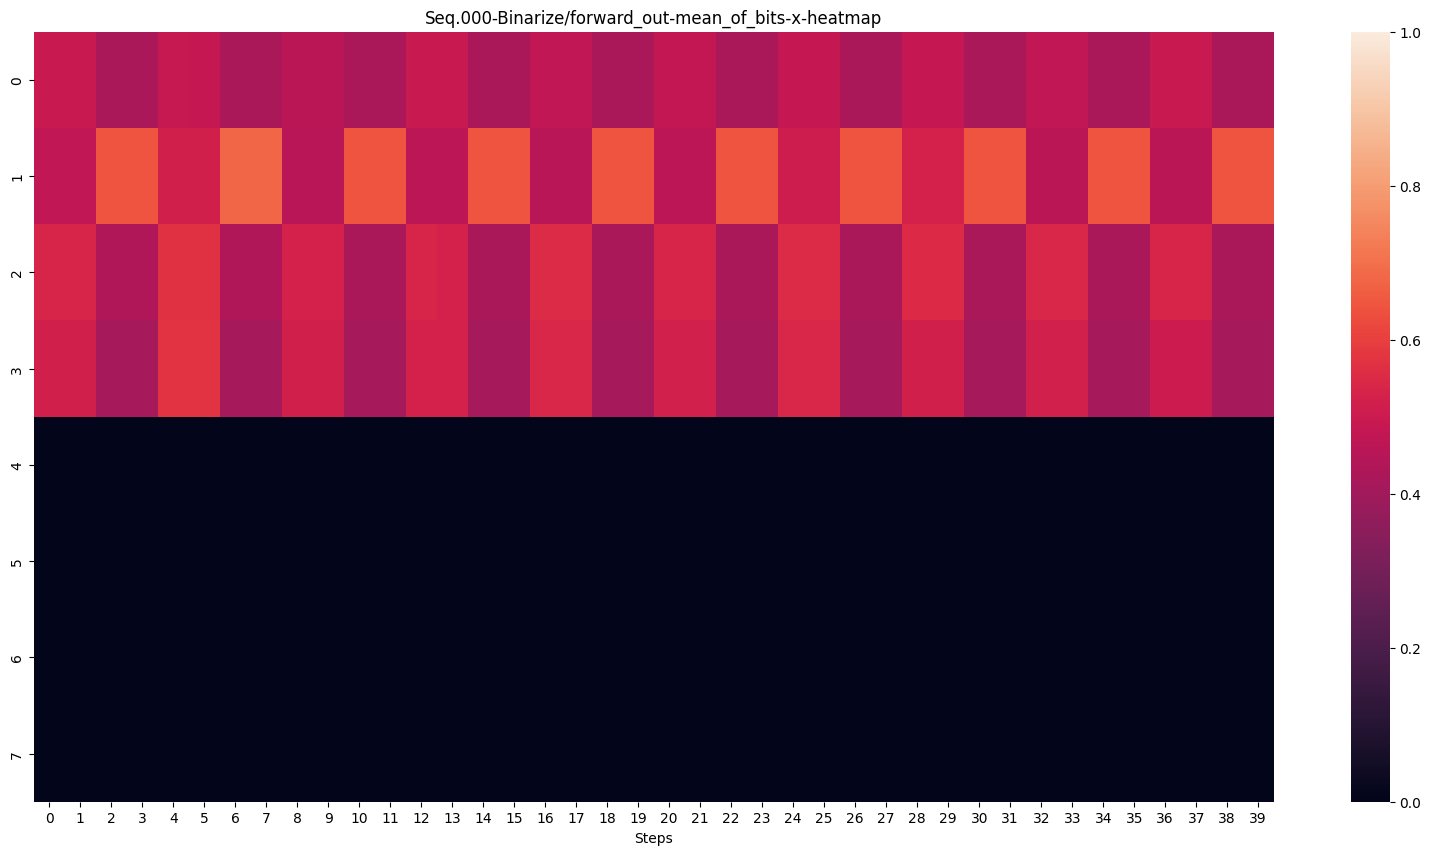

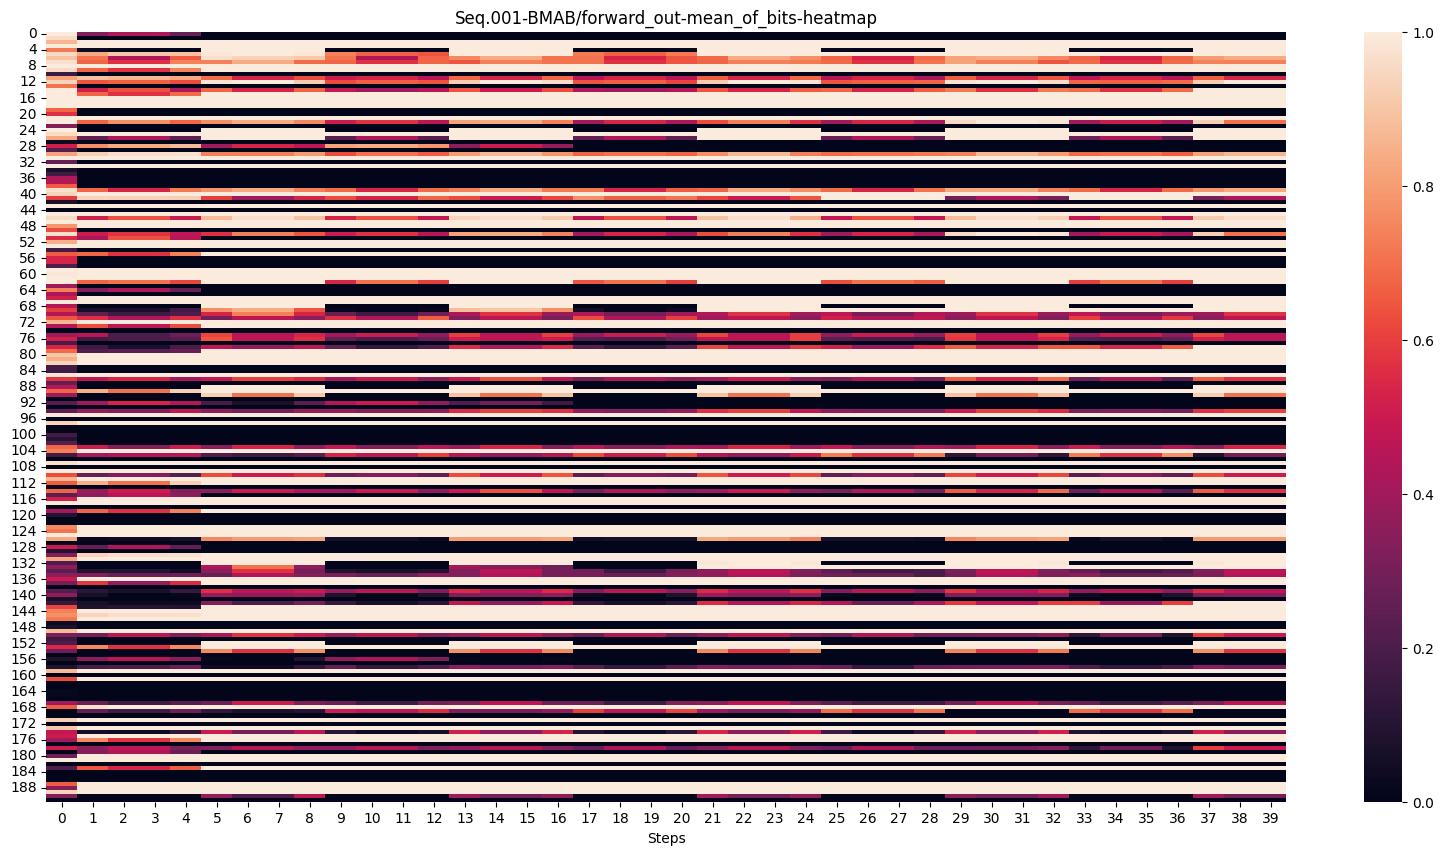

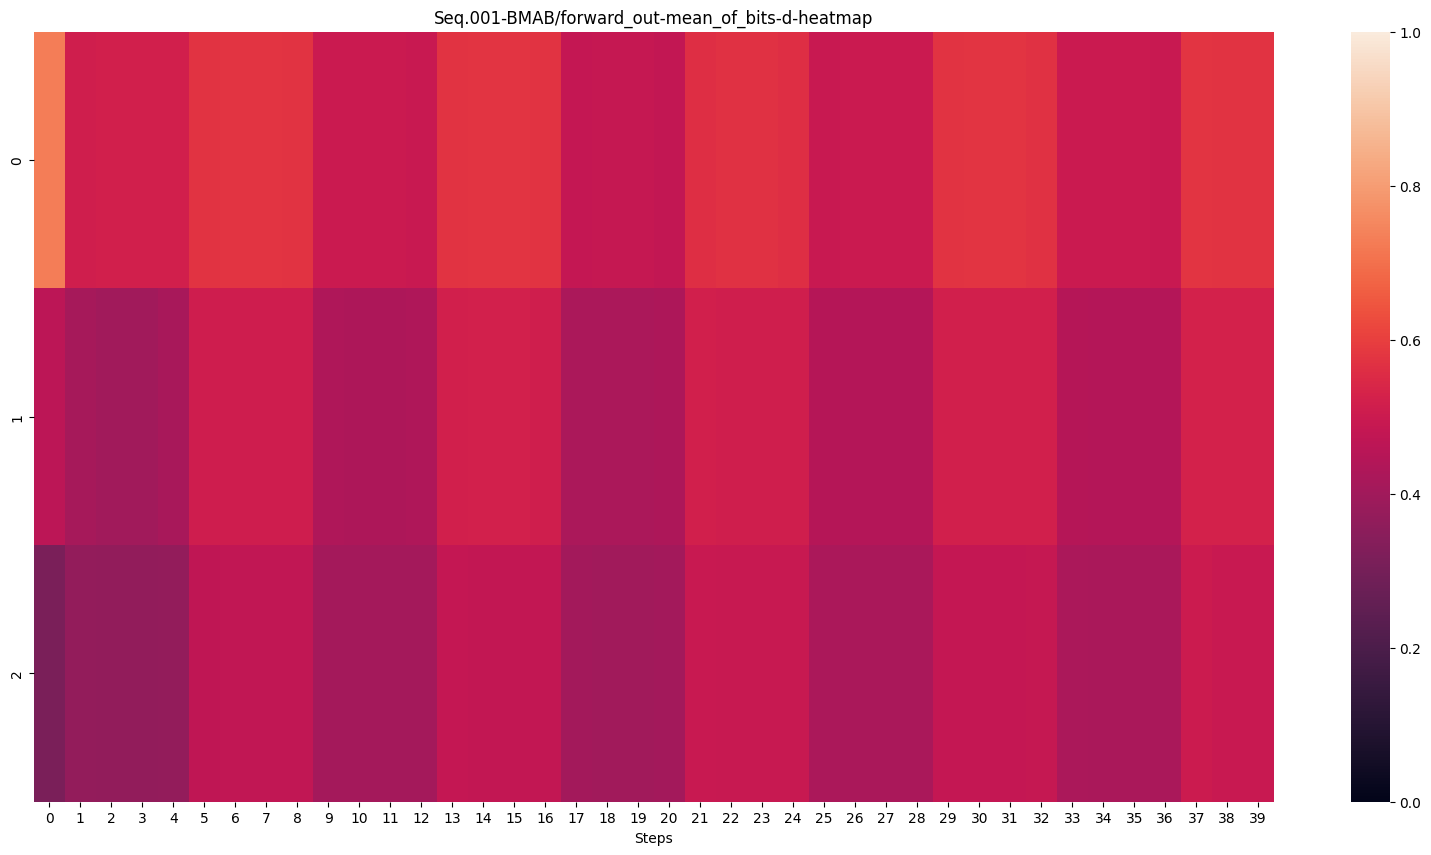

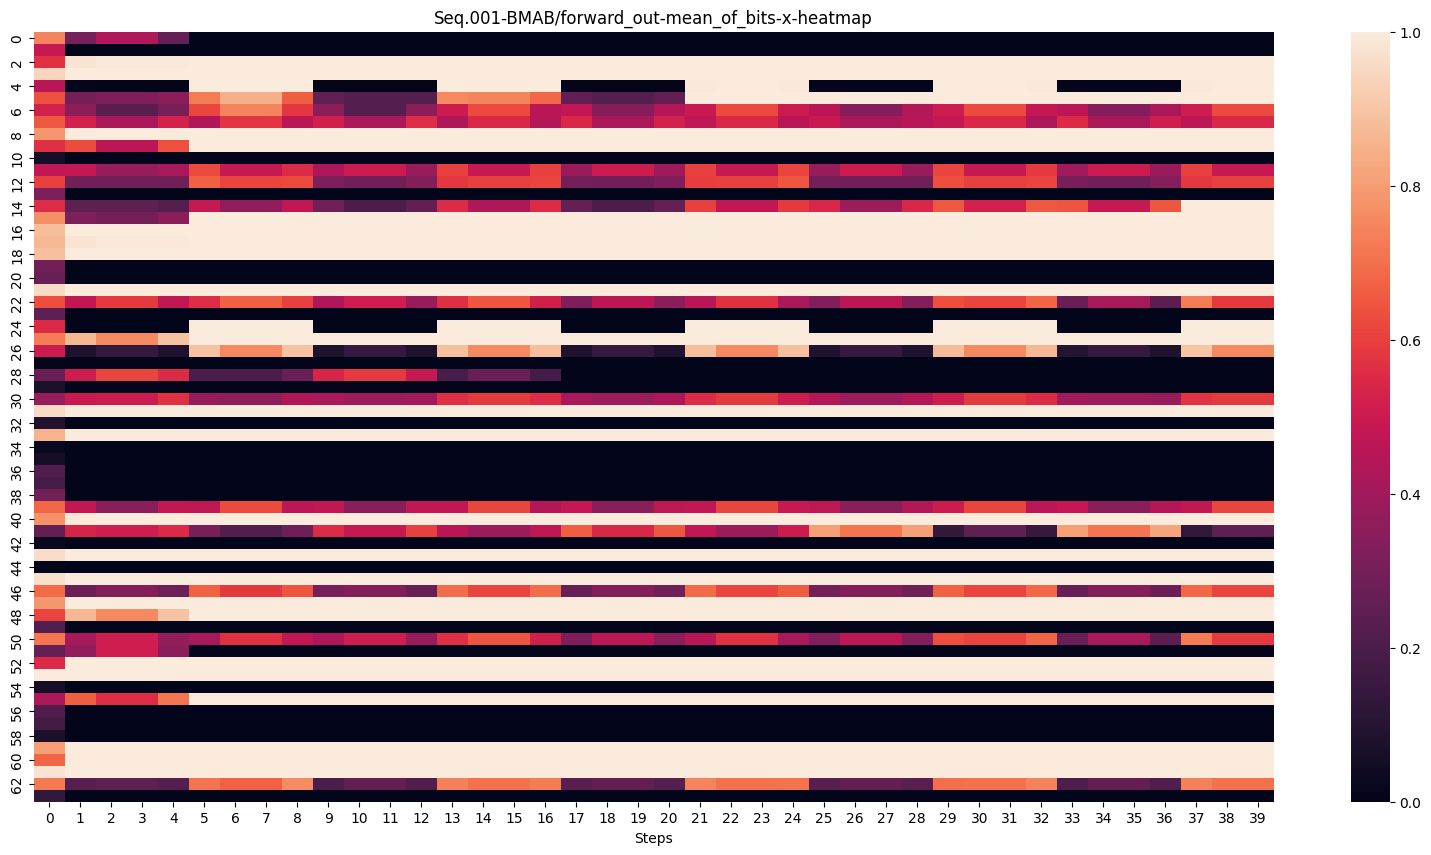

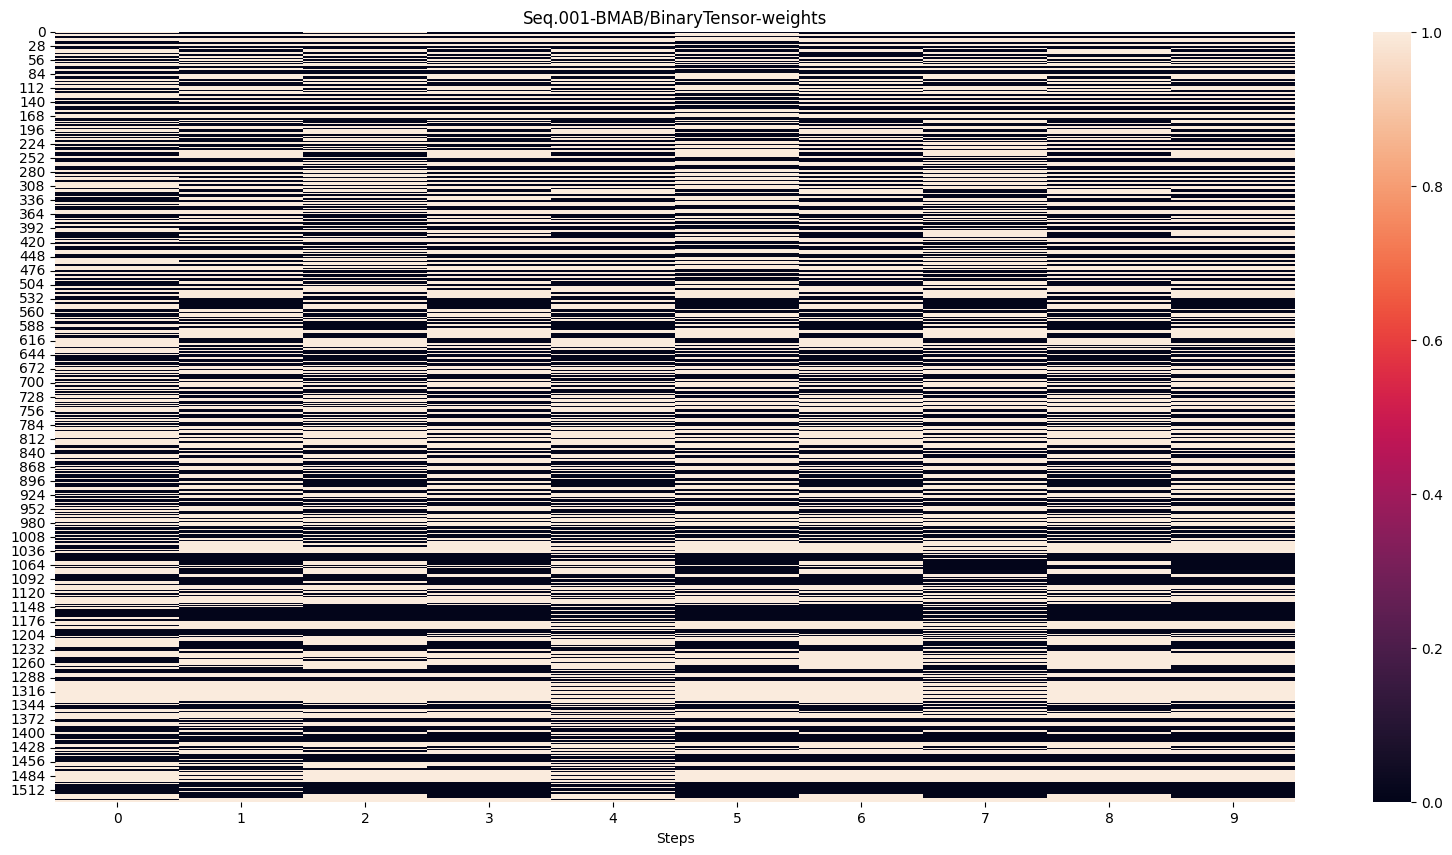

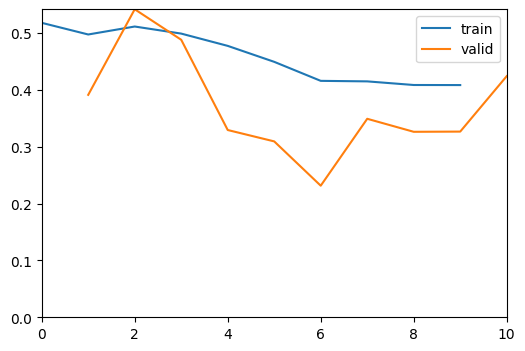

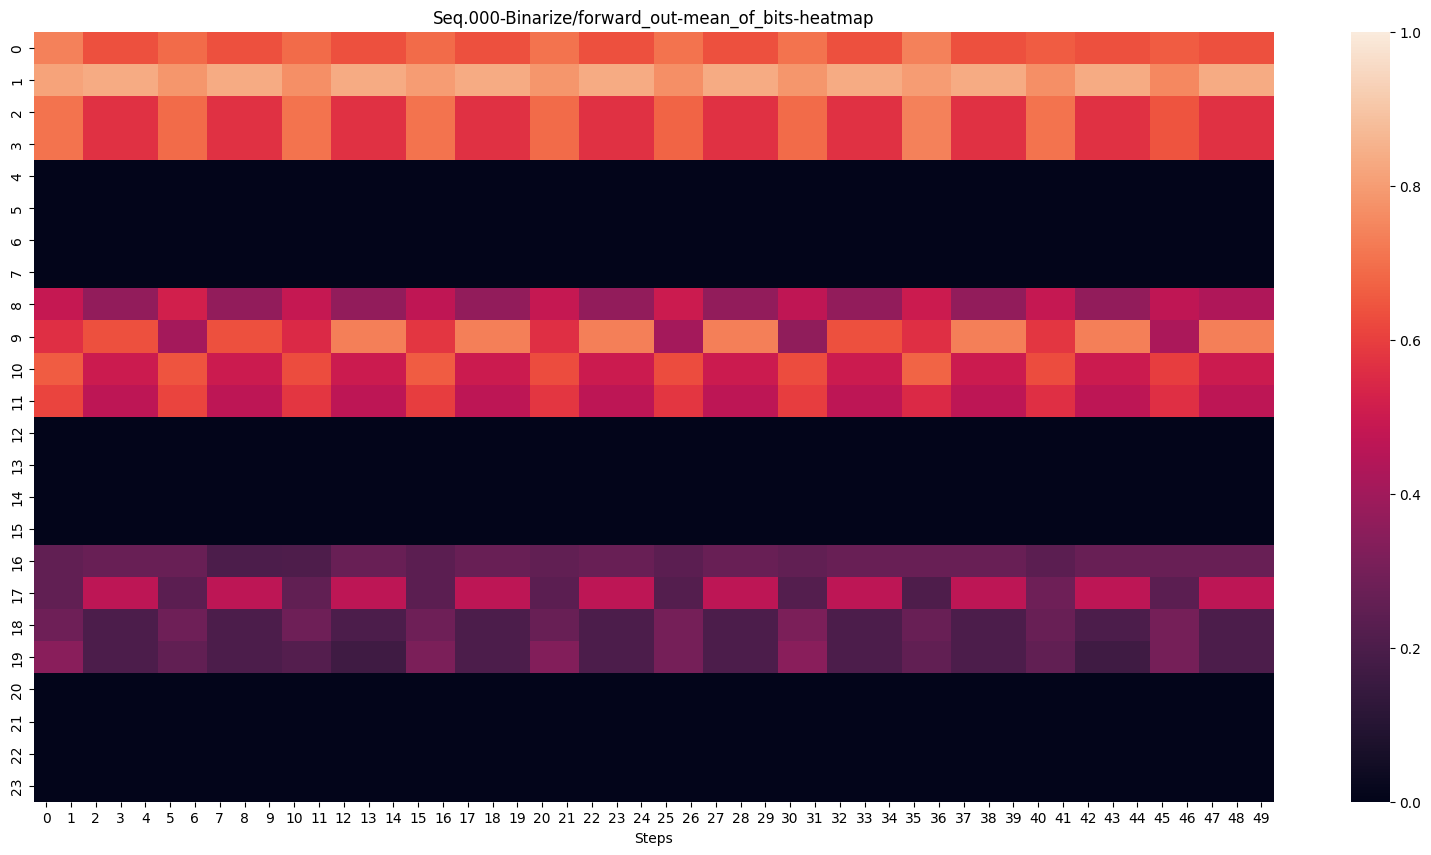

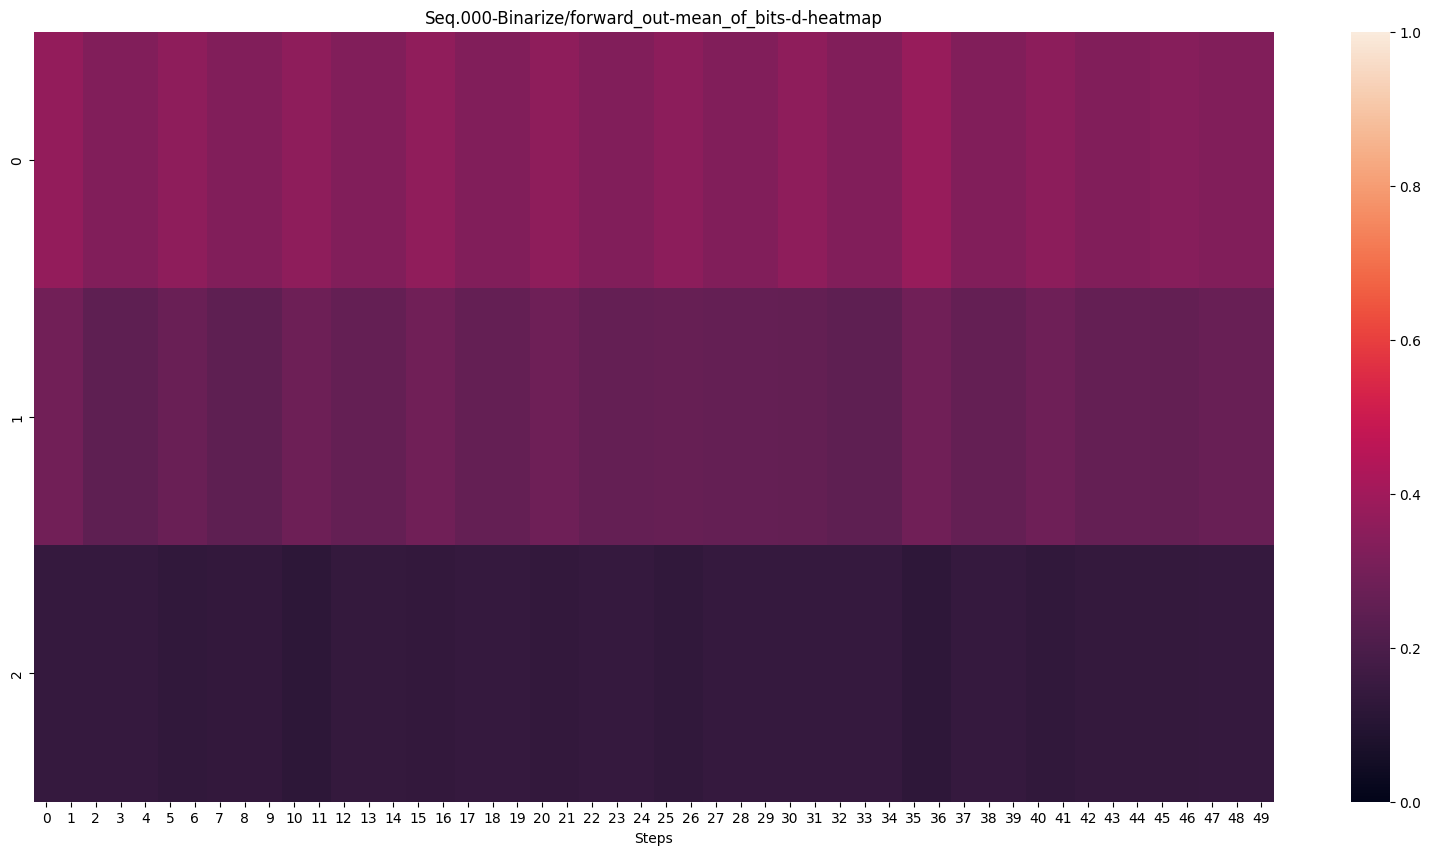

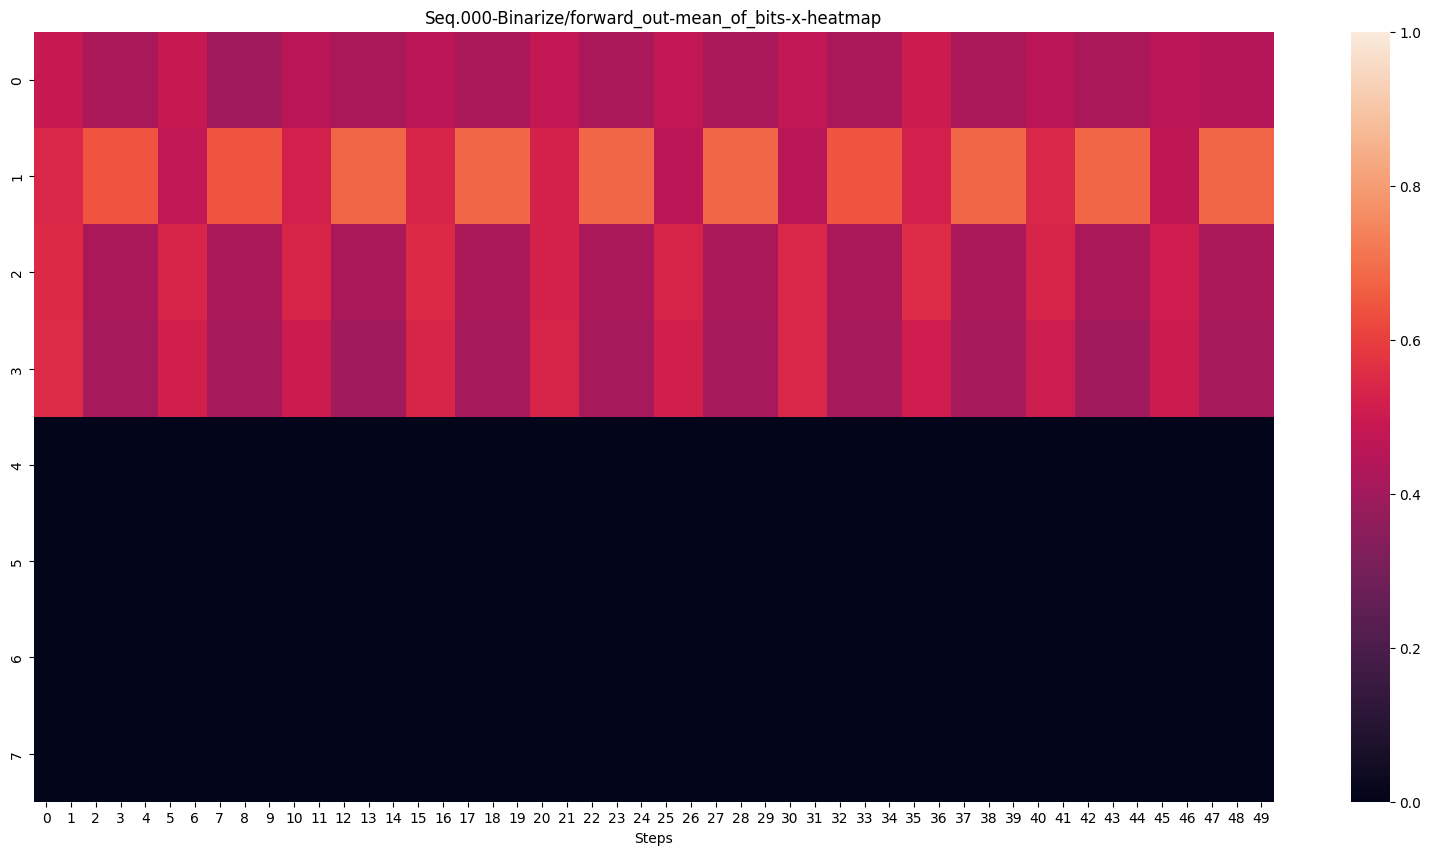

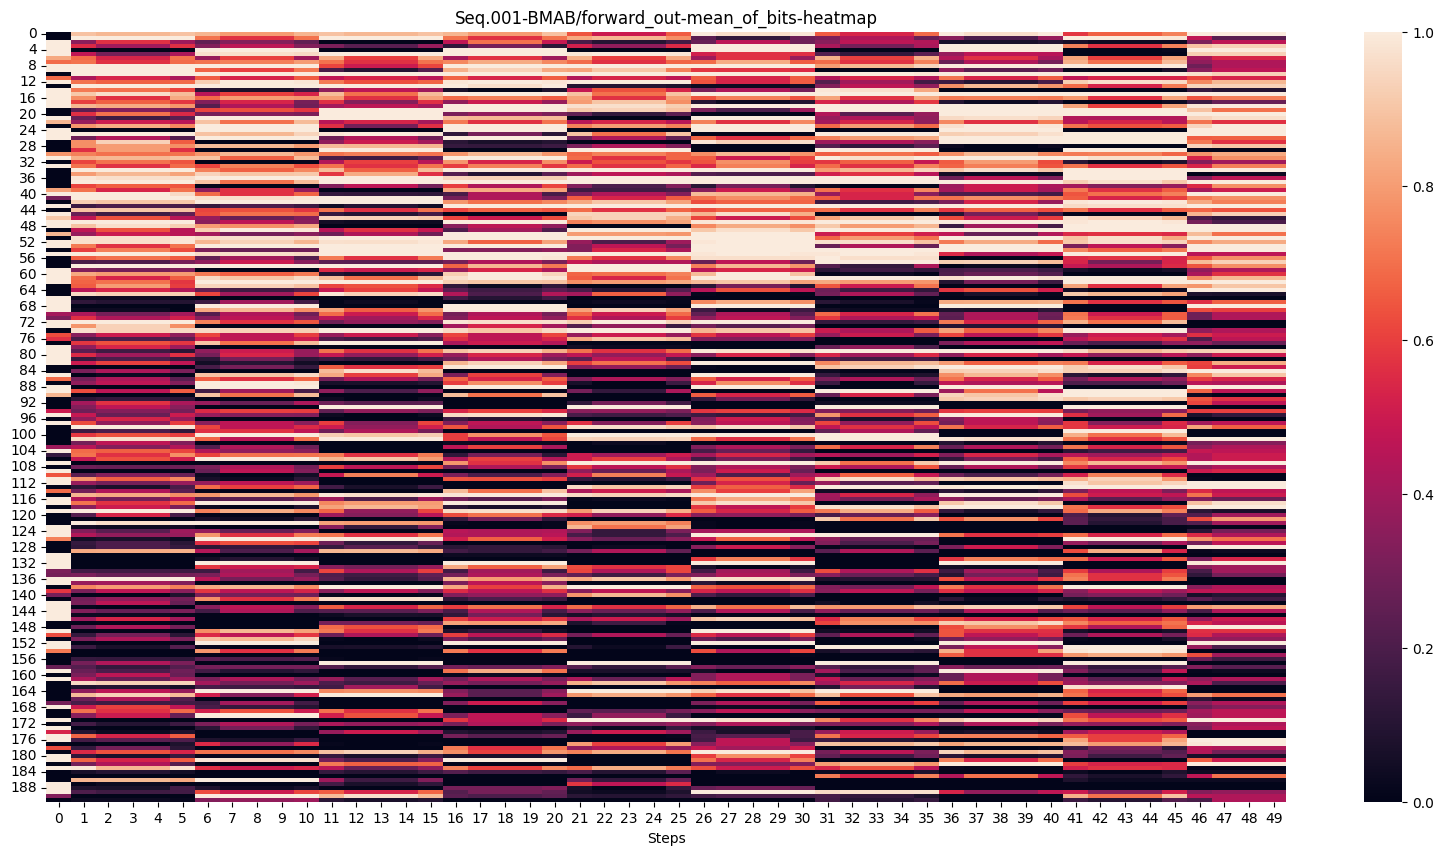

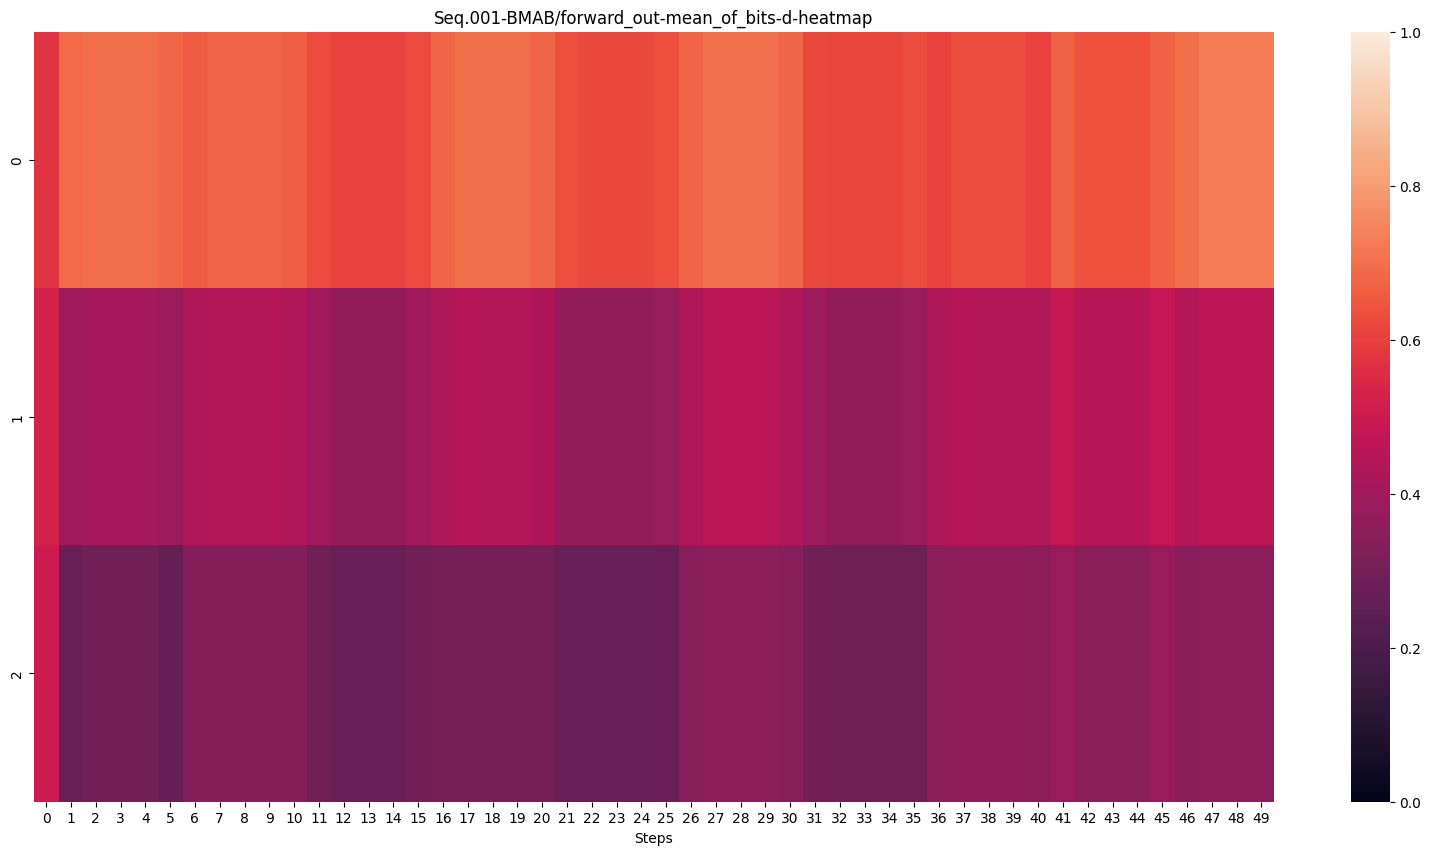

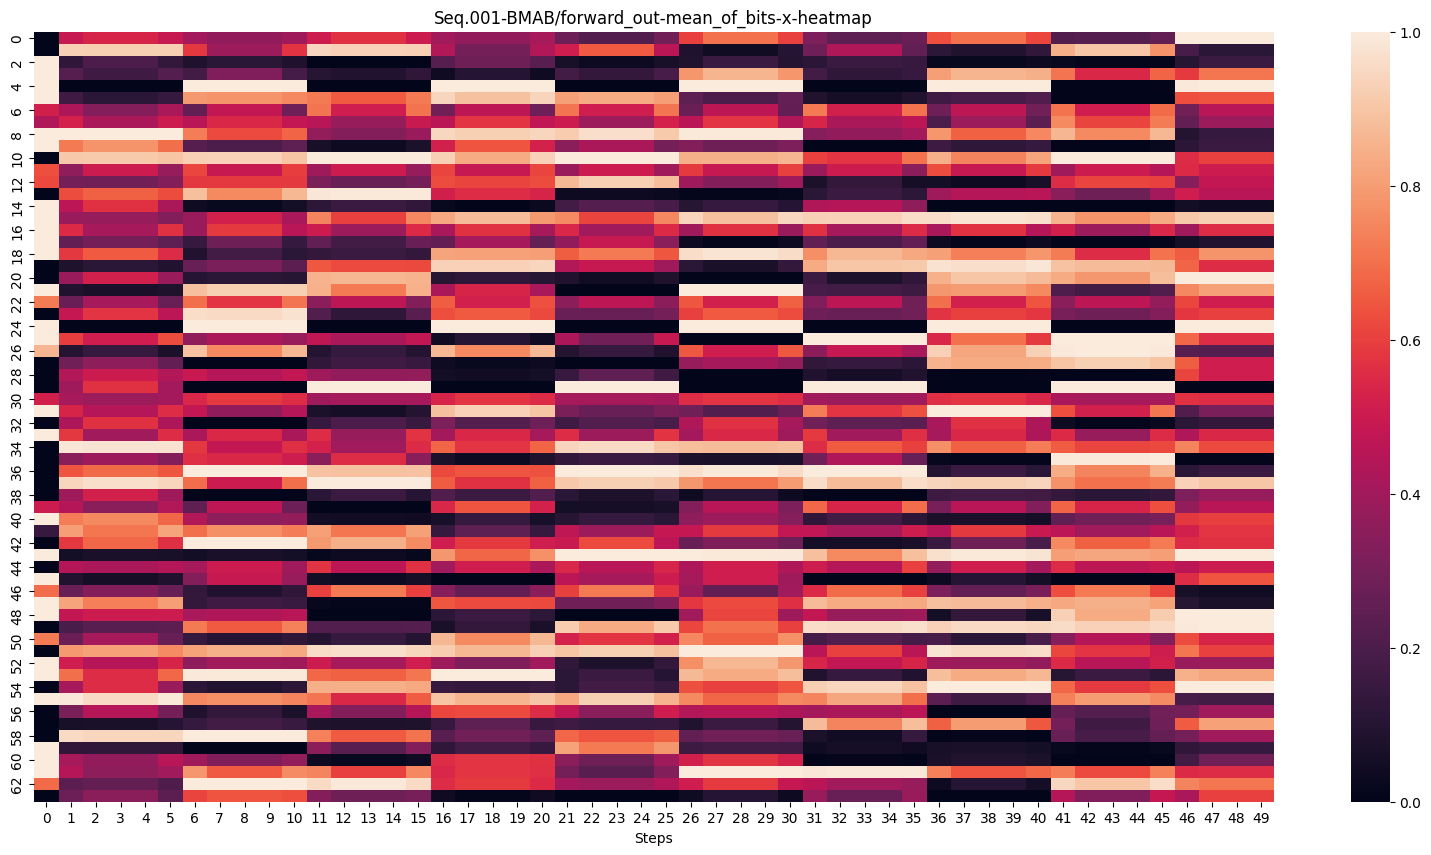

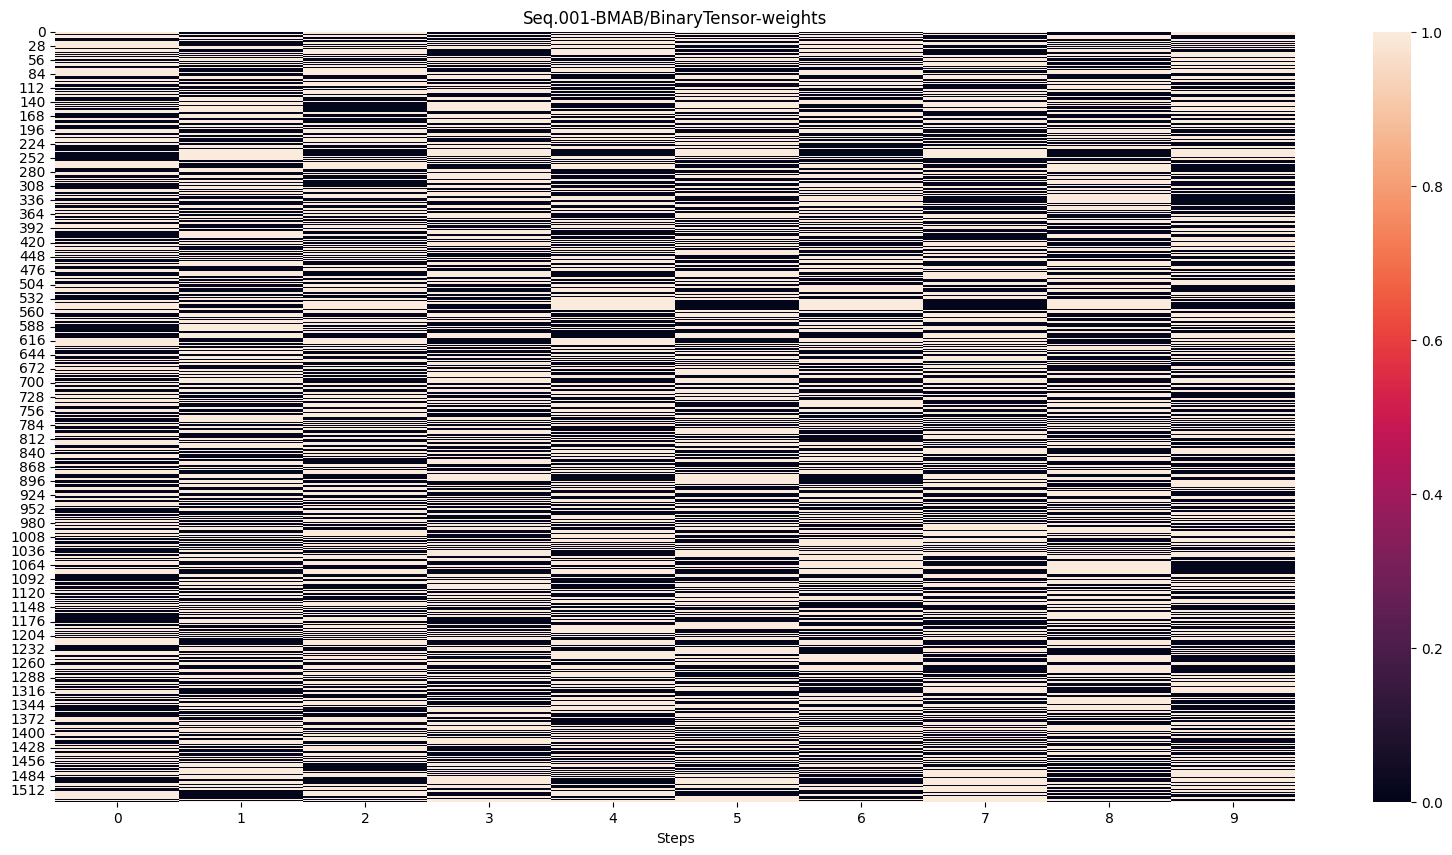

In [ ]:
model = Model02(input_dim, hidden_dim, output_dim, depth_features)
        
# Learn
wandb.init()  # new Run
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy,
               cbs=[CustomWandbCallback(),
                    BinaryLearnCallback([model.binary_net]),
                    ShowGraphCallback()])
# 1st learn
learn.dls.bs=32
bnn.update_permission_coef = 0  # allow 100%
learn.fit_one_cycle(10, lr_max=1e-2)
# 2nd learn
learn.dls.bs=len(dls.train_ds)
bnn.update_permission_coef = 1  # allow 50%
learn.fit_one_cycle(10, lr_max=1e-3)
wandb.finish()